<a href="https://colab.research.google.com/github/Johannes-Lotter/torchgooglecolabOCR/blob/main/PyTorch_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optical Character Recognition Using PyTorch

This project provides an implementation of an Optical Character Recognition (OCR) model using PyTorch. We train a Convolutional Neural Network (CNN) to recognize individual characters in natural images.

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

#To manage whether there is a google drive connected or not
drive_mounted = False

In [3]:
from google.colab import drive
try:
    drive.mount('/content/drive', force_remount=True)
    drive_mounted = True
except:
    drive_mounted = False

if drive_mounted:
    print("Google Drive is connected.")
else:
    print("Google Drive is not connected.")


Mounted at /content/drive
Google Drive is connected.


## Dataset

We make use of the [Chars74K dataset](http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/), which provides images of individual characters, including variations in scale, and maintaining the original resolution of the characters as they appear in the original images.

Specifically, we are using the `EnglishFnt.tgz` file, which contains characters from computer fonts with 4 variations (combinations of italic, bold, and normal). This dataset has 62 classes, consisting of digits 0-9, uppercase letters A-Z, and lowercase letters a-z.


In [ ]:
'''
The Chars74K dataset
Character Recognition in Natural Images
http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/
Images of individual characters: the files below contain directory trees of each dataset of individual characters. In these trees, there is one directory per class of character. Each character sample appear in an individual PNG image. There's a large variation is scale, as we kept the original resolution of the characters as they appear in the original images.
English, 62 classes (0-9, A-Z, a-z)
EnglishFnt.tgz (51.1 MB): characters from computer fonts with 4 variations (combinations of italic, bold and normal).
'''

import tarfile

if drive_mounted:
    tar = tarfile.open('/content/drive/MyDrive/Python_OCR/EnglishFnt.tgz')
else:
    !wget -O EnglishFnt.tgz http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz
    tar = tarfile.open('EnglishFnt.tgz')

tar.extractall('./EnglishFnt')
tar.close()

--2023-06-14 13:24:16--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz
Resolving www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)... 131.227.80.48
Connecting to www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49817950 (48M) [application/x-gzip]
Saving to: ‘EnglishFnt.tgz’

EnglishFnt.tgz      100%[===================>]  47.51M  14.6MB/s    in 3.3s    

2023-06-14 13:24:20 (14.6 MB/s) - ‘EnglishFnt.tgz’ saved [49817950/49817950]



## Task 1: Image Preprocessing

The images are preprocessed before feeding them into the model. The preprocessing steps include resizing the images, randomly flipping the images horizontally for data augmentation, converting the images into PyTorch tensors, and normalizing the pixel values.


In [9]:
data = torchvision.datasets.ImageFolder(
    root='./drive/MyDrive/TrainingData',
    transform=transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

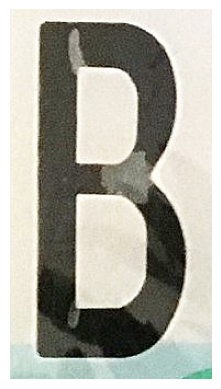

torch.Size([1, 3, 48, 48])


In [10]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Load and display the image
image_path = './drive/MyDrive/TrainingData/B/b1.jpg'  # Replace with the path to your actual image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
preprocessed_image = preprocess(image)

# Add a batch dimension
input_tensor = preprocessed_image.unsqueeze(0)

# Verify the shape of the input tensor
print(input_tensor.shape)

## Task 2: Data Loading and Preparation

We load the dataset and prepare it by splitting into training, validation, and testing sets.

In [7]:
def load_split(dataset, batch_size, test_split=0.3, random_seed=42):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    split = int(np.floor(test_split * dataset_size))
    train_indices, test_indices = indices[split:], indices[:split]

    testset_size = len(test_indices)
    indices = list(range(testset_size))
    np.random.seed(random_seed)
    np.random.shuffle(indices)

    split = int(np.floor(0.5 * testset_size))
    val_indices, test_indices = indices[split:], indices[:split]

    # Creating data samplers:
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    # Creating data loaders:
    train_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=train_sampler)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=test_sampler)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=val_sampler)

    return train_loader, test_loader, val_loader

In [8]:
batch_size = 36
train_loader, test_loader, val_loader = load_split(data, batch_size, test_split=0.3)

In [9]:
for batch in train_loader:
    images, labels = batch
    print(images.shape)  # Print the shape of the batch of images
    print(labels.shape)  # Print the shape of the batch of labels
    break  # Print only the first batch

torch.Size([36, 3, 48, 48])
torch.Size([36])


## Task 3: Building a CNN and One-hot-encoding

We then define a simple Convolutional Neural Network (CNN) architecture for the OCR model. The output size of the fully connected layer is set to 62, corresponding to the 62 classes in our dataset.

In [ ]:
# 1. Custom Dataset for multi-character OCR
class OCRDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.images = []
        self.char_to_idx = {ch: i for i, ch in enumerate("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")}
        self.idx_to_char = {i: ch for ch, i in self.char_to_idx.items()}
        self.pad_idx = 0  # Padding index

        # Parse dataset
        for root, _, files in os.walk(image_folder):
            for file in files:
                if file.endswith(".png"):
                    label = os.path.basename(root)
                    self.images.append((os.path.join(root, file), label))

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label_encoded = torch.tensor([self.char_to_idx[char] for char in label], dtype=torch.long)
        return image, label_encoded

    def __len__(self):
        return len(self.images)

In [1]:
# 2. CRNN Model
class CRNN(nn.Module):
    def __init__(self, num_classes, hidden_size=256):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.ReLU()
        )
        self.rnn = nn.LSTM(256, hidden_size, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        features = self.cnn(x)
        b, c, h, w = features.size()
        features = features.permute(0, 3, 1, 2).reshape(b, w, c * h)
        rnn_out, _ = self.rnn(features)
        outputs = self.fc(rnn_out)
        return outputs

NameError: name 'nn' is not defined

## Task 4: Set the Optimizer and Loss Functions

Stochastic Gradient Descent (SGD) is used as the optimizer, and Cross Entropy Loss is used as the loss function.

In [11]:
# 3. Loss Function
criterion = nn.CTCLoss()


## Task 5: Training the Model

The model is trained using the training set. The loss for each epoch is printed to monitor the training process.

In [12]:
# 4. Training Loop
def train_crnn(model, train_loader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            log_probs = F.log_softmax(outputs, dim=2)

            input_lengths = torch.full(size=(images.size(0),), fill_value=outputs.size(1), dtype=torch.long)
            target_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)
            labels = torch.cat([label for label in labels])

            loss = criterion(log_probs.permute(1, 0, 2), labels, input_lengths, target_lengths)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# 5. Inference Function
def decode_predictions(output, idx_to_char):
    output = output.permute(1, 0, 2)
    _, predictions = output.max(2)
    batch_text = []
    for pred in predictions:
        text = "".join([idx_to_char[idx.item()] for idx in torch.unique_consecutive(pred) if idx != 0])
        batch_text.append(text)
    return batch_text

# Initialize Dataset, Model, and Optimizer
transform = transforms.Compose([
    transforms.Resize((48, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [13]:
# Call the training function
train(model, train_loader, optimizer, criterion, num_epochs=20)


End of Epoch 1/20, Average Epoch Loss: 4.1173

End of Epoch 2/20, Average Epoch Loss: 3.9713

End of Epoch 3/20, Average Epoch Loss: 3.7242

End of Epoch 4/20, Average Epoch Loss: 3.4109

End of Epoch 5/20, Average Epoch Loss: 3.0481

End of Epoch 6/20, Average Epoch Loss: 2.6727

End of Epoch 7/20, Average Epoch Loss: 2.2244

End of Epoch 8/20, Average Epoch Loss: 1.6926

End of Epoch 9/20, Average Epoch Loss: 1.2178

End of Epoch 10/20, Average Epoch Loss: 0.8586

End of Epoch 11/20, Average Epoch Loss: 0.5570

End of Epoch 12/20, Average Epoch Loss: 0.3508

End of Epoch 13/20, Average Epoch Loss: 0.1955

End of Epoch 14/20, Average Epoch Loss: 0.1678

End of Epoch 15/20, Average Epoch Loss: 0.1051

End of Epoch 16/20, Average Epoch Loss: 0.0577

End of Epoch 17/20, Average Epoch Loss: 0.0368

End of Epoch 18/20, Average Epoch Loss: 0.0411

End of Epoch 19/20, Average Epoch Loss: 0.0223

End of Epoch 20/20, Average Epoch Loss: 0.0215


## Task 6: Validate the Model

After training, we validate the model using the validation set.

In [14]:
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

validate(model, val_loader, criterion)

Validation Loss: 0.1962, Validation Accuracy: 96.67%


## Task 7: Testing the Model

Finally, the model is tested using the test set.

In [15]:
def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

test(model, test_loader, criterion)

Test Loss: 0.0487, Test Accuracy: 100.00%


## Task 8: Saving and Loading the Model

We can save the trained model for later use or further training. To load the model, we first initialize an instance of the model and then load the parameters.

In [16]:
# Save model
if drive_mounted:
    torch.save(model.state_dict(), './drive/MyDrive/PythonOCR/PyTorch_OCR_20230614a.pth')
else:
    torch.save(model.state_dict(), '/content/PyTorch_OCR.pth')

In [8]:
# Load model
model = OCRNet(num_features)
if drive_mounted:
    model.load_state_dict(torch.load('/content/drive/MyDrive/PythonOCR/PyTorch_OCR_20230614a.pth'))
else:
    model.load_state_dict(torch.load('./drive/MyDrive/Python_OCR/PyTorch_OCR.pth'))
model.eval()  # Ensure the model is in evaluation mode

<ipython-input-8-e6ac8611b058>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/PythonOCR/PyTorch_OCR_20230614a.pth'

OCRNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=73728, out_features=62, bias=True)
)

## Task 9: Making Predictions

The trained model can be used to predict the class of a single image.

Predicted Class: B, Confidence: 94.25%


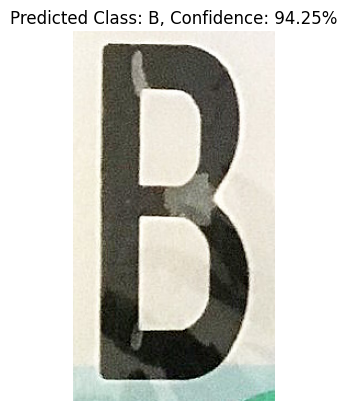

In [11]:
import torch.nn.functional as F

char_to_idx = {ch: i for i, ch in enumerate("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz")}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}

def predict(model, image_path, transform):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB
    image = transform(image).unsqueeze(0)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        predicted_prob, predicted_idx = torch.max(probabilities, 1)
        predicted_class = classes[predicted_idx]

        confidence = predicted_prob.item() * 100  # convert to percentage
        print(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%')

    plt.imshow(Image.open(image_path))
    plt.title(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()

# Specify the path to your image
#image_path = '/content/EnglishFnt/English/Fnt/Sample049/img049-00001.png'
image_path = '/content/drive/MyDrive/TrainingData/B/b1.jpg'

predict(model, image_path, preprocess)

In [1]:
!pip install onnx
!pip install onnxscript
import onnx
import onnxscript

torch_input = torch.randn(16, 3, 48, 48);
onnx_program = torch.onnx.dynamo_export(model, torch_input)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 726.7/726.7 kB 9.6 MB/s eta 0:00:00


NameError: name 'torch' is not defined

In [28]:
onnx_program.save("./drive/MyDrive/PythonOCR/PythonOCRV1.onnx")

In [6]:
onnx_model = onnx.load(".//drive/MyDrive/PythonOCR/PythonOCRV1.onnx")
print("Input names:", [input.name for input in onnx_model.graph.input])

Input names: ['l_x_']
